<a href="https://colab.research.google.com/github/tharaka-w/PD/blob/main/Full_Framework_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set path to dataset
dataset_path = '/content/drive/MyDrive/PD_Spiral_Dataset'




Mounted at /content/drive


In [ ]:
ll

total 176
drwx------ 5 root   4096 Sep 21 13:33 drive/
drwxr-xr-x 1 root   4096 Sep 16 13:40 sample_data/
-rw-r--r-- 1 root 169867 Sep 21 13:34 spiral_features_new.csv


In [ ]:
from google.colab import files
files.download('/content/spiral_features_new.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set path to dataset
dataset_path = '/content/drive/MyDrive/PD_Spiral_Dataset'




Mounted at /content/drive



✅ Saved features CSV: /content/spiral_features_new_increased2.csv
Rows: 116  |  Columns: 89

▶ Plot: resized_spiral_batch2_4_256.png  [healthy]


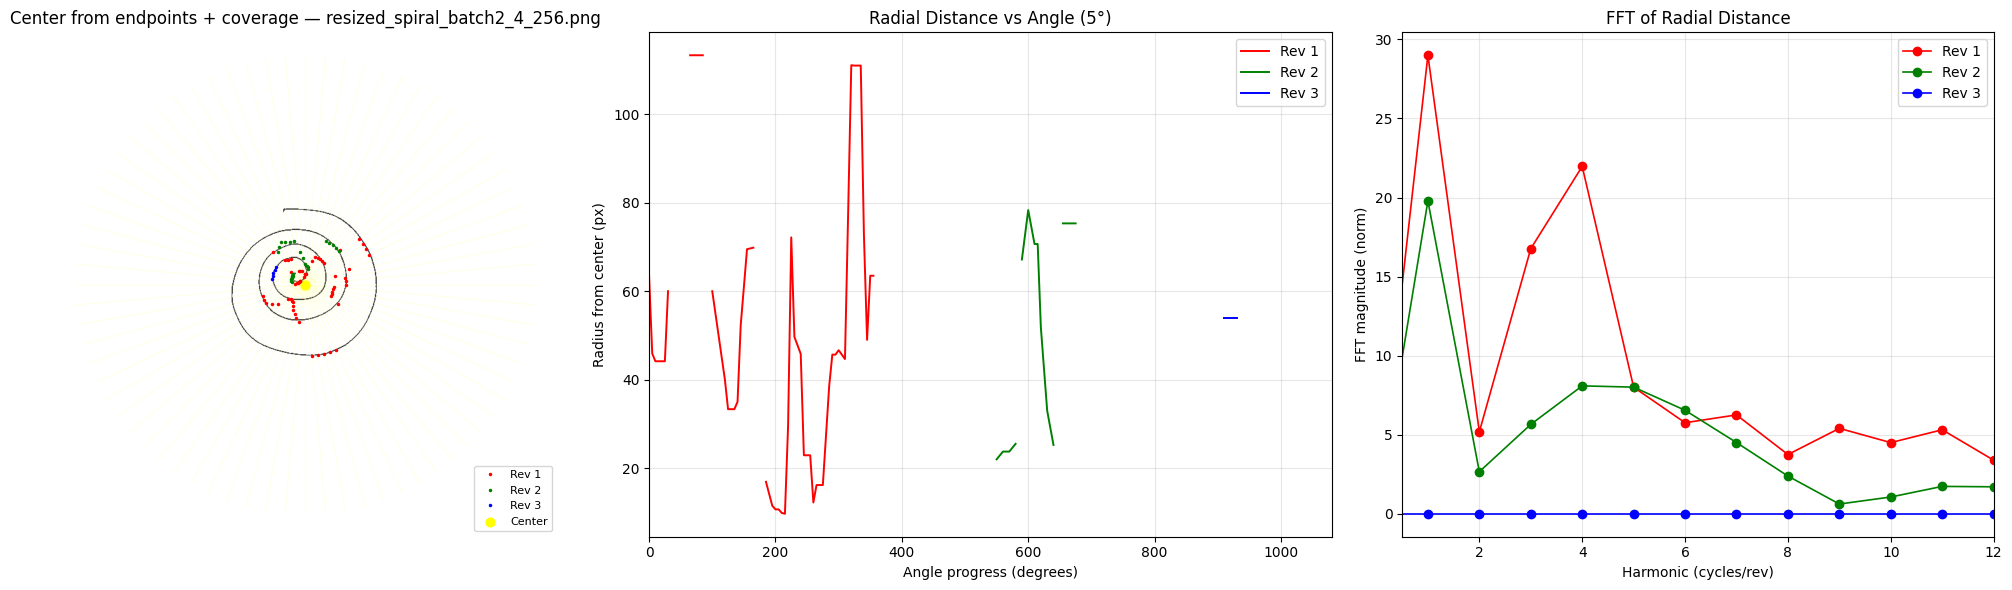


▶ Plot: Copy of V08HE01.png  [healthy]


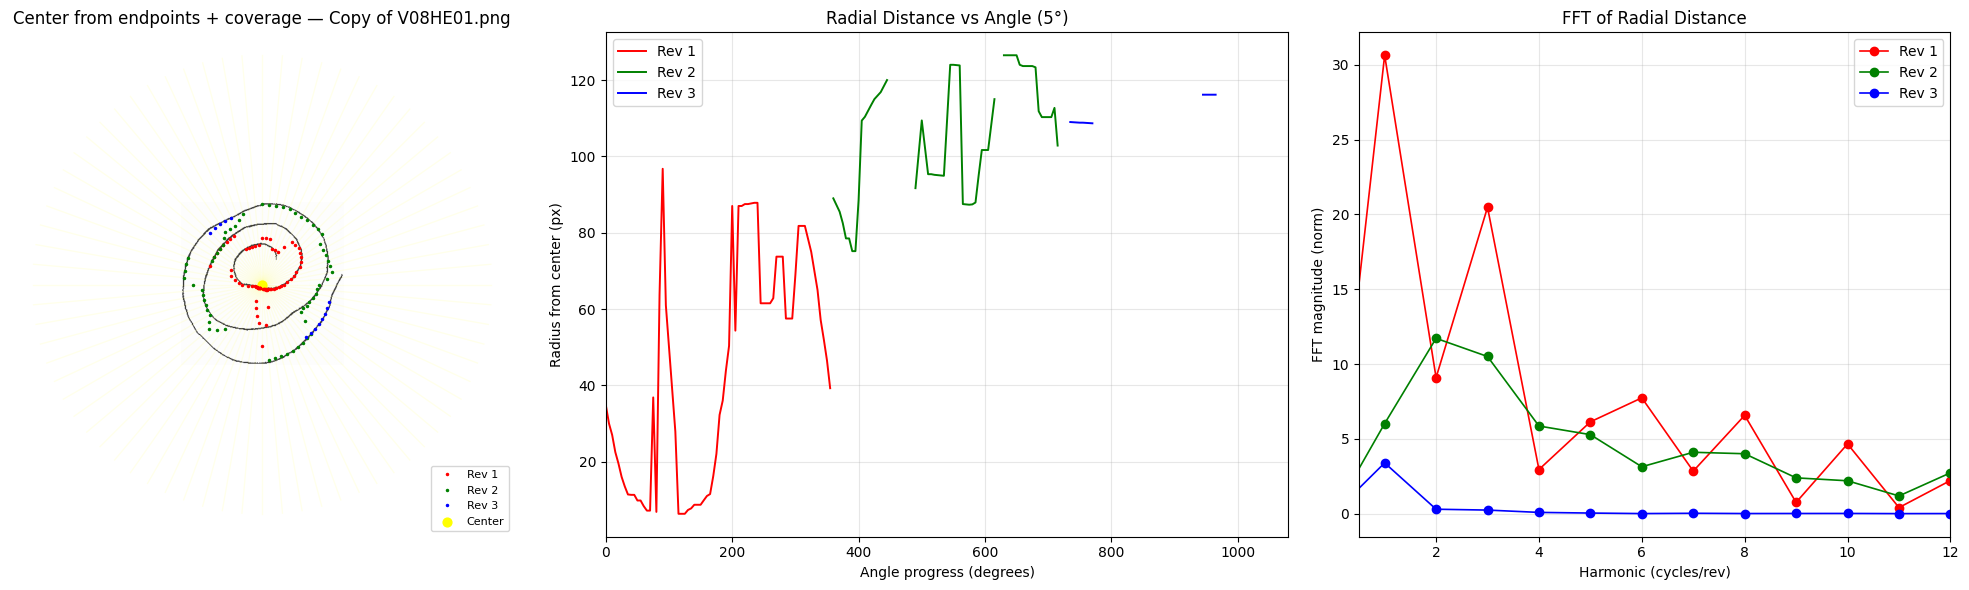


▶ Plot: Copy of V02PE01.png  [parkinson]


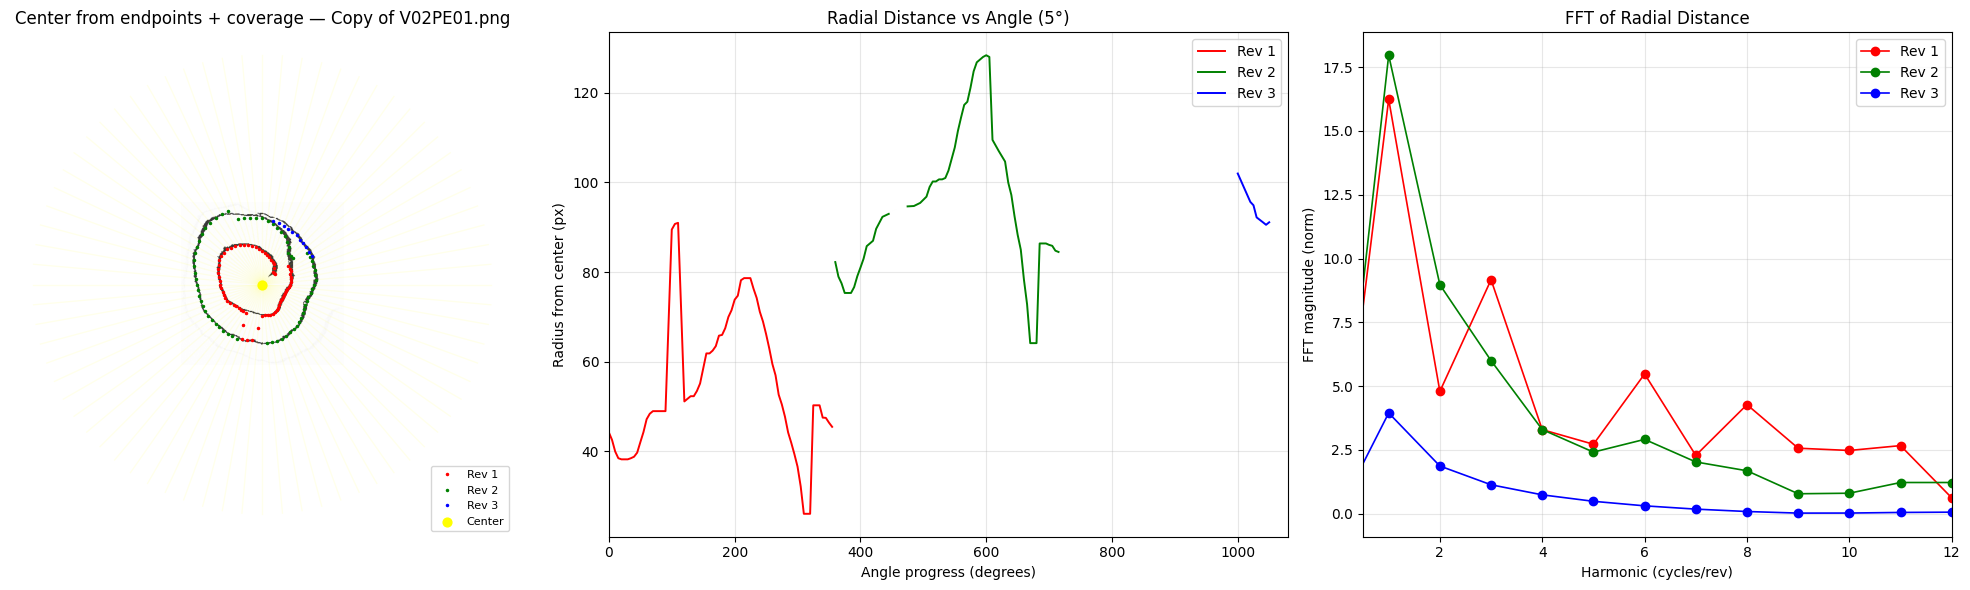


▶ Plot: resized_spiral_batch11_5_256.png  [parkinson]


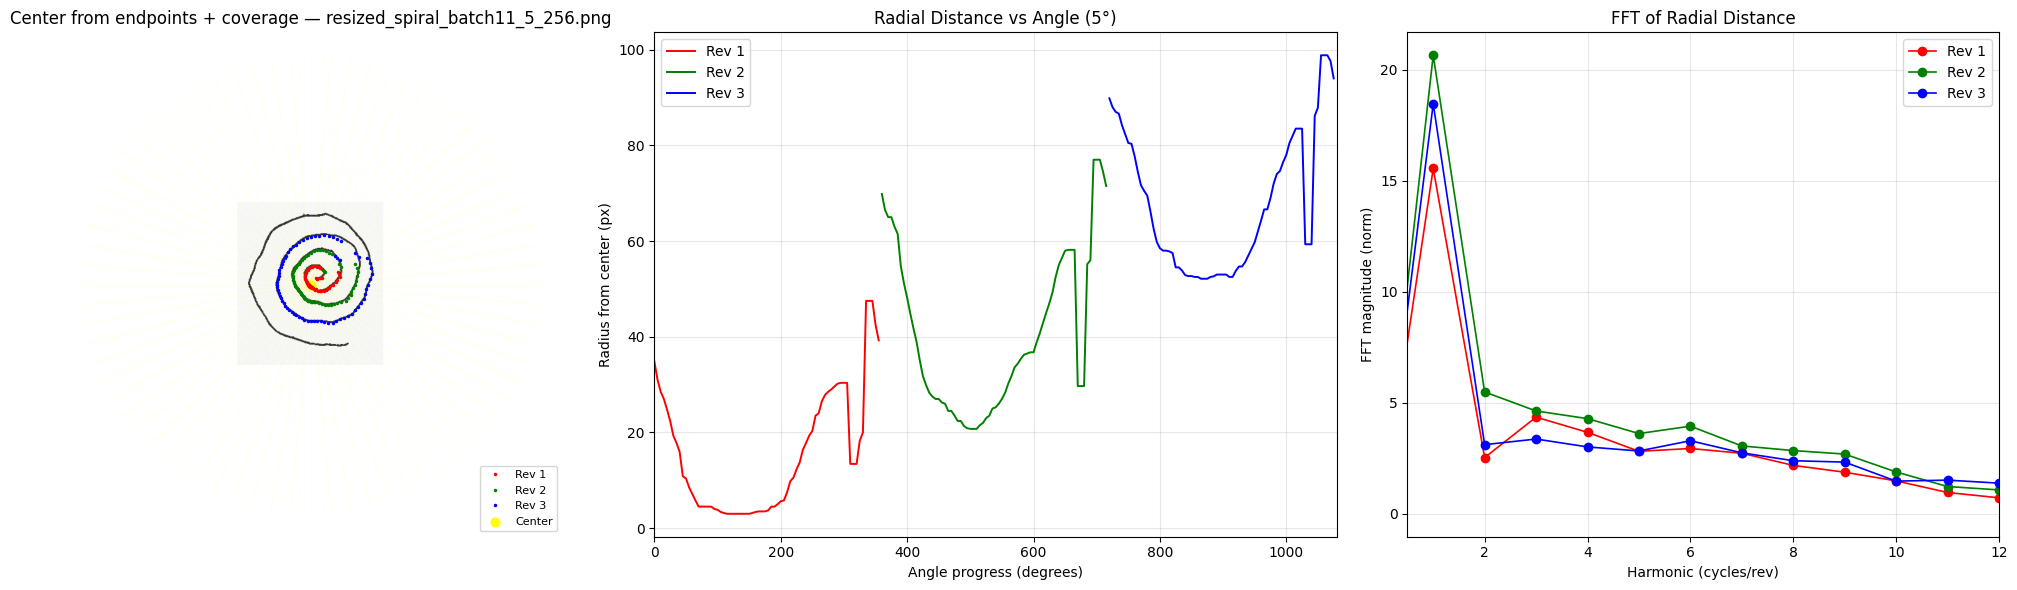

In [ ]:
# ===========================================
# Colab one-cell: Spiral features (healthy vs parkinson)
# - Robust center from endpoints + angular coverage
# - Direct 3-rev sampling per 5° ray (no peel)
# - Plot a few examples (for verification)
# - Extract MANY features from rings and FFT
# - Save one CSV for ALL images in both folders
# ===========================================

# --- deps ---
!pip -q install opencv-python scikit-image numpy matplotlib pandas

import os, glob, random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage.morphology import skeletonize
from skimage.util import img_as_bool

# -------- CONFIG: paths & knobs --------
BASE_TRAIN = "/content/drive/MyDrive/PD_Dataset_new/Parkinson Dataset/dataset/spiral/training"
TRAIN_HEALTHY   = os.path.join(BASE_TRAIN, "healthy")
TRAIN_PARKINSON = os.path.join(BASE_TRAIN, "parkinson")

REVS = 3                    # how many revolutions to extract per ray
ANGLE_STEP_DEG = 5.0        # 5° sampling
R_STEP_PX = 0.5             # radial sampling step along a ray
MIN_RUN_LEN = 3             # min consecutive ink pixels to accept a run
MIN_BG_GAP = 2              # min background pixels separating runs
SMOOTH_WIN = 5              # median smoothing window (odd; 0/1 disables)
FILL_GAP_DEG = 10.0         # fill NaN runs up to this many degrees

MAX_HARMONIC_TO_SHOW = 12
REMOVE_DC = True

N_VERIFY_PLOTS_PER_CLASS = 2   # how many images to PLOT from each folder (only for visual check)
RANDOM_SEED = 42
SAVE_CSV_PATH = "/content/spiral_features_new_increased2.csv"
# --------------------------------------

# ---------- binarize/polarity ----------
ADAPT_BLOCK = 41
ADAPT_C = 10
MORPH_CLOSE_K = 3
KEEP_LARGEST_IF_FRAC = 0.5
POLARITY_MIN_WHITE_FRAC = 0.55

def force_white_background(img_bin, min_white_frac=POLARITY_MIN_WHITE_FRAC):
    if float(np.mean(img_bin == 255)) < min_white_frac:
        img_bin = 255 - img_bin
    return img_bin

def binarize_conservative(img_gray):
    _, otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adapt = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, ADAPT_BLOCK, ADAPT_C)
    bin_or = cv2.bitwise_or(otsu, adapt)
    bin_or = force_white_background(bin_or)
    if MORPH_CLOSE_K >= 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_CLOSE_K, MORPH_CLOSE_K))
        inv = 255 - bin_or
        inv = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, k, iterations=1)
        bin_or = 255 - inv
    return force_white_background(bin_or)

def keep_largest_component_guarded(img_bin, keep_fraction=KEEP_LARGEST_IF_FRAC):
    ink = (img_bin == 0).astype(np.uint8)
    total = int(ink.sum())
    if total == 0: return img_bin
    num, labels, stats, _ = cv2.connectedComponentsWithStats(ink, 8)
    if num <= 2: return img_bin
    areas = stats[1:, cv2.CC_STAT_AREA]
    li = 1 + int(np.argmax(areas))
    if int(areas.max()) >= keep_fraction * total:
        keep = (labels == li)
        out = np.full_like(img_bin, 255, np.uint8); out[keep] = 0
        return out
    return img_bin

# ---------- skeleton + endpoints ----------
def get_skeleton_endpoints(img_bin):
    ink = (img_bin == 0).astype(np.uint8)
    skel = skeletonize(img_as_bool(ink))
    ys, xs = np.where(skel)

    H, W = img_bin.shape
    endpoints = []
    for y, x in zip(ys, xs):
        y0, y1 = max(0, y-1), min(H, y+2)
        x0, x1 = max(0, x-1), min(W, x+2)
        nb = np.count_nonzero(skel[y0:y1, x0:x1]) - 1
        if nb == 1:
            endpoints.append((x, y))
    if len(endpoints) >= 2:
        ep = np.array(endpoints)
        best = (0, (ep[0], ep[1]))
        for i in range(len(ep)):
            d = np.sum((ep[i] - ep)**2, axis=1)
            j = int(np.argmax(d))
            if d[j] > best[0]:
                best = (d[j], (tuple(ep[i]), tuple(ep[j])))
        e1, e2 = best[1]
    elif len(endpoints) == 1:
        e1, e2 = endpoints[0], endpoints[0]
    else:
        e1 = e2 = (img_bin.shape[1]//2, img_bin.shape[0]//2)
    return skel, np.array(list(zip(xs,ys))), e1, e2

# ---------- center from endpoints + angular coverage ----------
def circular_variance(angles):
    v = np.exp(1j * angles)
    return 1.0 - np.abs(np.mean(v))  # 0 = aligned, 1 = uniform coverage

def score_center(center, pts, sample_size=400):
    cx, cy = center
    if pts.shape[0] == 0:
        return -1e9
    if pts.shape[0] > sample_size:
        idx = np.random.RandomState(0).choice(pts.shape[0], sample_size, replace=False)
        P = pts[idx]
    else:
        P = pts
    dx = P[:,0] - cx
    dy = P[:,1] - cy
    m = (dx*dx + dy*dy) > 4.0
    if not np.any(m):
        return -1e9
    ang = np.arctan2(dy[m], dx[m])  # -π..π
    ang = (ang + 2*np.pi) % (2*np.pi)
    return circular_variance(ang)

def refine_center_by_angular_coverage(img_bin, seeds, pts, coarse=5, fine=2):
    H, W = img_bin.shape
    best = (-1e9, seeds[0])
    for (sx, sy) in seeds:
        sx = int(np.clip(sx, 0, W-1)); sy = int(np.clip(sy, 0, H-1))
        cx, cy = sx, sy
        for step in [coarse, fine]:
            improved = True
            while improved:
                improved = False
                base = score_center((cx, cy), pts)
                for dx in (-step, 0, step):
                    for dy in (-step, 0, step):
                        nx, ny = int(np.clip(cx+dx, 0, W-1)), int(np.clip(cy+dy, 0, H-1))
                        sc = score_center((nx, ny), pts)
                        if sc > base:
                            cx, cy, base = nx, ny, sc
                            improved = True
                if base > best[0]:
                    best = (base, (cx, cy))
    return best[1]

def estimate_center_from_endpoints(img_bin):
    H, W = img_bin.shape
    skel, pts, e1, e2 = get_skeleton_endpoints(img_bin)
    mid = ((e1[0]+e2[0])//2, (e1[1]+e2[1])//2)
    white = (img_bin == 255).astype(np.uint8) * 255
    dist = cv2.distanceTransform(white, cv2.DIST_L2, 5)
    y, x = np.unravel_index(np.argmax(dist), dist.shape)
    dt_peak = (int(x), int(y))
    ys, xs = np.where((img_bin == 0))
    centroid = (int(np.mean(xs)) if xs.size else W//2, int(np.mean(ys)) if ys.size else H//2)
    seeds = [mid, dt_peak, centroid]
    cx, cy = refine_center_by_angular_coverage(img_bin, seeds, pts)
    return int(cx), int(cy)

# ---------- ray sampling (first K ink runs) ----------
def ray_coords(cx, cy, theta_rad, r_max, r_step=R_STEP_PX, H=None, W=None):
    r = np.arange(0.0, r_max, r_step, dtype=np.float32)
    x = cx + r*np.cos(theta_rad)
    y = cy + r*np.sin(theta_rad)
    xi = np.rint(x).astype(int)
    yi = np.rint(y).astype(int)
    if H is not None and W is not None:
        m = (xi>=0)&(xi<W)&(yi>=0)&(yi<H)
        xi, yi, r = xi[m], yi[m], r[m]
    if xi.size > 1:
        dup = (np.diff(xi)==0) & (np.diff(yi)==0)
        keep = np.ones_like(xi, bool); keep[1:] &= ~dup
        xi, yi, r = xi[keep], yi[keep], r[keep]
    return xi, yi, r

def first_k_runs_along_ray(img_bin, xi, yi, r, k=3, min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP):
    ink = (img_bin[yi, xi] == 0).astype(np.int8)
    runs = []
    i = 0
    n = len(ink)
    while i < n and len(runs) < k:
        while i < n and ink[i] == 0: i += 1
        s = i
        while i < n and ink[i] == 1: i += 1
        e = i
        if e - s >= min_run:
            runs.append(float(np.mean(r[s:e])))
        gap = 0
        while i < n and ink[i] == 0 and gap < min_gap:
            i += 1; gap += 1
    if len(runs) < k:
        runs += [np.nan]*(k - len(runs))
    return runs[:k]

def sample_rings(img_bin, cx, cy, angle_step=ANGLE_STEP_DEG, k_revs=REVS):
    H, W = img_bin.shape
    r_max = float(np.hypot(W, H))
    angles_deg = np.arange(0.0, 360.0, angle_step, dtype=float)
    rings = np.full((k_revs, len(angles_deg)), np.nan, float)
    for j, ang in enumerate(angles_deg):
        th = np.deg2rad(ang)
        xi, yi, r = ray_coords(cx, cy, th, r_max, R_STEP_PX, H, W)
        if len(xi) == 0: continue
        runs = first_k_runs_along_ray(img_bin, xi, yi, r, k=k_revs,
                                      min_run=MIN_RUN_LEN, min_gap=MIN_BG_GAP)
        rings[:, j] = runs
    return angles_deg, rings

# ---------- smoothing / fill ----------
def _median_filter_circ(arr, w):
    if w<=1 or w%2==0: return arr
    n=len(arr); out=arr.copy(); h=w//2
    for i in range(n):
        idx=[(i+d)%n for d in range(-h,h+1)]
        seg=arr[idx]; seg=seg[np.isfinite(seg)]
        if seg.size: out[i]=np.median(seg)
    return out

def _fill_small_gaps(arr, max_gap_bins):
    out=arr.copy(); n=len(arr); i=0
    while i<n:
        if np.isnan(out[i]):
            j=i
            while j<n and np.isnan(out[j]): j+=1
            if i>0 and j<n and (j-i)<=max_gap_bins:
                out[i:j]=np.linspace(out[i-1], out[j], (j-i)+2)[1:-1]
            i=j
        else: i+=1
    return out

def tidy_rings(rings, angle_step=ANGLE_STEP_DEG, smooth_win=SMOOTH_WIN, fill_gap_deg=FILL_GAP_DEG):
    max_gap_bins = int(round(fill_gap_deg/angle_step)) if fill_gap_deg>0 else 0
    out=rings.copy()
    for k in range(out.shape[0]):
        r=out[k]
        if max_gap_bins>0: r=_fill_small_gaps(r, max_gap_bins)
        if smooth_win and smooth_win%2==1 and smooth_win>1: r=_median_filter_circ(r, smooth_win)
        out[k]=r
    return out

# ---------- FFT ----------
def ring_fft(sig):
    x=sig.astype(float)
    if np.any(~np.isfinite(x)):
        n=len(x); idx=np.arange(n); m=np.isfinite(x)
        if m.sum()==0: x=np.zeros_like(x)
        else:
            xi=np.concatenate([idx[m], idx[m]+n]); yi=np.concatenate([x[m],x[m]])
            idx2=idx.copy(); idx2[idx<idx[m].min()]+=n
            x=np.interp(idx2, xi, yi)
    if REMOVE_DC: x=x-np.mean(x)
    R=np.fft.rfft(x); mag=np.abs(R)/len(x); mag[1:-1]*=2.0
    h=np.arange(len(mag)); return h, mag

# ---------- plotting ----------
def plot_all(img_gray, img_bin, cx, cy, angles, rings, fft_h, fft_mag, title):
    colors=['red','green','blue','purple','orange']
    fig=plt.figure(figsize=(20,6))
    gs=fig.add_gridspec(1,3,width_ratios=[1.2,1.5,1.3])
    ax0=fig.add_subplot(gs[0,0]); ax1=fig.add_subplot(gs[0,1]); ax2=fig.add_subplot(gs[0,2])

    ax0.imshow(img_gray,cmap='gray',alpha=0.25)
    ax0.imshow(img_bin,cmap='gray',alpha=0.75)
    H,W=img_bin.shape; edge=int(np.hypot(W,H))
    for ang in angles:
        x2=int(round(cx+edge*np.cos(np.deg2rad(ang))))
        y2=int(round(cy+edge*np.sin(np.deg2rad(ang))))
        ax0.plot([cx,x2],[cy,y2],color='yellow',alpha=0.08,linewidth=1)
    for k in range(min(REVS, rings.shape[0])):
        m=np.isfinite(rings[k]); th=np.deg2rad(angles[m]); rr=rings[k,m]
        xs=cx+rr*np.cos(th); ys=cy+rr*np.sin(th)
        ax0.plot(xs,ys,'.',color=colors[k%len(colors)],markersize=3,label=f"Rev {k+1}")
    ax0.scatter(cx,cy,c='yellow',s=40,label='Center'); ax0.axis('off'); ax0.legend(loc='lower right',fontsize=8)
    ax0.set_title(f"Center from endpoints + coverage — {title}")

    for k in range(min(REVS, rings.shape[0])):
        ax1.plot(angles+360.0*k, rings[k], color=colors[k%len(colors)], linewidth=1.4, label=f"Rev {k+1}")
    ax1.set_xlim(0, 360.0*REVS); ax1.grid(True,alpha=0.3)
    ax1.set_xlabel("Angle progress (degrees)"); ax1.set_ylabel("Radius from center (px)")
    ax1.set_title(f"Radial Distance vs Angle ({ANGLE_STEP_DEG:.0f}°)"); ax1.legend()

    for k in range(min(REVS, rings.shape[0])):
        h, m = fft_h[k], fft_mag[k]; mask = (h<=MAX_HARMONIC_TO_SHOW)
        ax2.plot(h[mask], m[mask], marker='o', linewidth=1.2, label=f"Rev {k+1}", color=colors[k%len(colors)])
    ax2.set_xlabel("Harmonic (cycles/rev)"); ax2.set_ylabel("FFT magnitude (norm)")
    ax2.set_title("FFT of Radial Distance"); ax2.grid(True,alpha=0.3); ax2.legend()
    if REMOVE_DC: ax2.set_xlim(0.5, MAX_HARMONIC_TO_SHOW)
    else:         ax2.set_xlim(0, MAX_HARMONIC_TO_SHOW)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---------- Feature extraction ----------
def _finite(x): return np.isfinite(x)

def _linfit_slope_deg(angles_deg, y):
    m = _finite(y)
    if m.sum() < 6: return np.nan
    x = angles_deg[m]
    yy = y[m]
    x = x - x.mean()
    denom = (x*x).sum()
    if denom == 0: return 0.0
    return float((x*yy).sum()/denom)

def _num_gaps_and_maxgap(ang, y):
    m = _finite(y)
    if m.all(): return 0, 0.0
    mask = ~m.astype(bool)
    gaps = 0; maxgap = 0.0
    n = len(mask)
    i = 0
    step_deg = float(ang[1]-ang[0])
    while i < n:
        if mask[i]:
            j = i
            while j < n and mask[j]: j += 1
            gaps += 1
            maxgap = max(maxgap, (j - i) * step_deg)
            i = j
        else:
            i += 1
    if mask[0] and mask[-1]:
        i0 = 0
        while i0 < n and mask[i0]: i0 += 1
        jn = n-1
        while jn >= 0 and mask[jn]: jn -= 1
        merged = (i0 + (n-1-jn)) * step_deg
        maxgap = max(maxgap, merged)
        gaps = max(0, gaps-1)
    return gaps, float(maxgap)

def _residuals(y):
    m = _finite(y)
    if m.sum()==0: return np.full_like(y, np.nan, dtype=float)
    med = np.nanmedian(y)
    r = y - med
    r[~m] = np.nan
    return r

def _derivative(x):
    y = x.copy()
    m = _finite(y)
    if m.sum() < 3: return np.full_like(y, np.nan, dtype=float)
    # circular forward diff
    d = np.roll(y, -1) - y
    d[~m] = np.nan
    return d

def _zcr(x):
    m = _finite(x)
    x = x[m]
    if len(x) < 3: return np.nan
    s = np.sign(x)
    s[s==0] = 1
    return float(np.mean(s[:-1] != s[1:]))

def _safe_corr(a, b):
    m = _finite(a) & _finite(b)
    if m.sum() < 6: return np.nan
    aa = a[m]; bb = b[m]
    if np.std(aa)==0 or np.std(bb)==0: return np.nan
    return float(np.corrcoef(aa, bb)[0,1])

def _spec_bands(h, mag):
    # ignore DC (0)
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan, np.nan, np.nan
    hh = h[m]; mm = mag[m]
    low = (hh>=2) & (hh<=4)
    mid = (hh>=5) & (hh<=8)
    high= (hh>=9) & (hh<=12)
    e_low  = float((mm[low]**2).sum()) if np.any(low) else 0.0
    e_mid  = float((mm[mid]**2).sum()) if np.any(mid) else 0.0
    e_high = float((mm[high]**2).sum()) if np.any(high) else 0.0
    return e_low, e_mid, e_high

def _spec_centroid(h, mag):
    m = (h>=1) & _finite(mag)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); mm = mag[m].astype(float)
    s = mm.sum()
    if s==0: return np.nan
    return float((hh*mm).sum()/s)

def _spec_entropy(mag):
    m = _finite(mag)
    mm = mag[m].astype(float)
    if mm.size == 0: return np.nan
    s = mm.sum()
    if s <= 0: return np.nan
    p = mm / s
    p = p[p>0]
    return float(-(p*np.log(p)).sum())

def _spec_decay(h, mag):
    m = (h>=1) & _finite(mag) & (mag>0)
    if not np.any(m): return np.nan
    hh = h[m].astype(float); lg = np.log(mag[m].astype(float))
    X = np.vstack([hh, np.ones_like(hh)]).T
    w = np.linalg.lstsq(X, lg, rcond=None)[0]
    return float(w[0])  # slope (more negative = steeper decay)

def compute_features(angles_deg, rings, fft_h, fft_mag):
    out = {}
    step_deg = float(angles_deg[1] - angles_deg[0]) if len(angles_deg)>1 else ANGLE_STEP_DEG

    for k in range(REVS):
        r = rings[k]
        m = _finite(r)
        coverage = float(np.mean(m)) if r.size else 0.0
        gaps, maxgap = _num_gaps_and_maxgap(angles_deg, r)

        out[f"r{k+1}_coverage_frac"] = coverage
        out[f"r{k+1}_num_gaps"]      = gaps
        out[f"r{k+1}_max_gap_deg"]   = maxgap

        out[f"r{k+1}_mean"]   = float(np.nanmean(r)) if m.any() else np.nan
        out[f"r{k+1}_median"] = float(np.nanmedian(r)) if m.any() else np.nan
        out[f"r{k+1}_std"]    = float(np.nanstd(r)) if m.any() else np.nan
        out[f"r{k+1}_ptp"]    = float(np.nanmax(r)-np.nanmin(r)) if m.any() else np.nan
        out[f"r{k+1}_slope_deg"] = _linfit_slope_deg(angles_deg, r)

        # monotonic breaks (sign changes in derivative of r)
        dr = _derivative(r)
        if np.all(~_finite(dr)):
            out[f"r{k+1}_monotonic_breaks"] = np.nan
        else:
            s = np.sign(dr)
            s[~_finite(s)] = 0
            s[s==0] = 1
            out[f"r{k+1}_monotonic_breaks"] = float(np.sum(s[:-1] != s[1:]))

        # residual-based roughness
        res = _residuals(r)
        out[f"r{k+1}_res_rms"] = float(np.sqrt(np.nanmean(res**2))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_mad"] = float(np.nanmedian(np.abs(res - np.nanmedian(res)))) if _finite(res).any() else np.nan
        out[f"r{k+1}_res_ptp"] = float(np.nanmax(res)-np.nanmin(res)) if _finite(res).any() else np.nan
        dres = _derivative(res)
        out[f"r{k+1}_deriv_rms"] = float(np.sqrt(np.nanmean(dres**2))) if _finite(dres).any() else np.nan
        out[f"r{k+1}_zcr"] = _zcr(dres)

        # spectrum
        h = fft_h[k]; mag = fft_mag[k]
        if REMOVE_DC:
            h0 = h[1:]; mag0 = mag[1:]
        else:
            h0 = h.copy(); mag0 = mag.copy()
        if mag0.size:
            dom_idx = int(np.argmax(mag0))
            out[f"r{k+1}_dom_harm"] = int(h0[dom_idx])
            out[f"r{k+1}_dom_amp"]  = float(mag0[dom_idx])
        else:
            out[f"r{k+1}_dom_harm"] = np.nan
            out[f"r{k+1}_dom_amp"]  = np.nan

        e_low, e_mid, e_high = _spec_bands(h, mag)
        out[f"r{k+1}_E_low_2_4"]  = e_low
        out[f"r{k+1}_E_mid_5_8"]  = e_mid
        out[f"r{k+1}_E_high_9_12"] = e_high
        out[f"r{k+1}_E_hi_lo_ratio"] = float(e_high / e_low) if e_low>0 else np.nan
        out[f"r{k+1}_spec_centroid"] = _spec_centroid(h, mag)
        out[f"r{k+1}_spec_entropy"]  = _spec_entropy(mag)
        out[f"r{k+1}_spec_decay"]    = _spec_decay(h, mag)

    # inter-ring spacing & coherence
    for (a,b) in [(0,1),(1,2)]:
        if a < rings.shape[0] and b < rings.shape[0]:
            ra, rb = rings[a], rings[b]
            spacing = rb - ra
            m = _finite(spacing)
            out[f"r{a+1}{b+1}_spacing_mean"] = float(np.nanmean(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_std"]  = float(np.nanstd(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_min"]  = float(np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_ptp"]  = float(np.nanmax(spacing)-np.nanmin(spacing)) if m.any() else np.nan
            out[f"r{a+1}{b+1}_spacing_cv"]   = (out[f"r{a+1}{b+1}_spacing_std"] / out[f"r{a+1}{b+1}_spacing_mean"]) if m.any() and out[f"r{a+1}{b+1}_spacing_mean"] not in [0, np.nan] else np.nan
            # crossings: inner > outer? (spacing < 0)
            out[f"r{a+1}{b+1}_crossing_frac"] = float(np.mean(spacing[m] < 0.0)) if m.any() else np.nan

            # residual correlation
            res_a = _residuals(ra)
            res_b = _residuals(rb)
            out[f"r{a+1}{b+1}_corr_resid"] = _safe_corr(res_a, res_b)

            # fft magnitude correlation
            out[f"r{a+1}{b+1}_corr_fft"] = _safe_corr(fft_mag[a], fft_mag[b])

    return out

# ---------- run folders, plot some, write CSV ----------
def list_images(folder):
    exts=("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    paths=[]
    for e in exts: paths+=glob.glob(os.path.join(folder,e))
    paths.sort()
    return paths

def process_image(path):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise ValueError(f"Cannot read: {path}")
    img_bin = binarize_conservative(img_gray)
    img_bin = keep_largest_component_guarded(img_bin, KEEP_LARGEST_IF_FRAC)
    img_bin = force_white_background(img_bin)

    cx, cy = estimate_center_from_endpoints(img_bin)
    angles, rings_raw = sample_rings(img_bin, cx, cy, ANGLE_STEP_DEG, REVS)
    rings = tidy_rings(rings_raw, ANGLE_STEP_DEG, SMOOTH_WIN, FILL_GAP_DEG)

    fft_h=[]; fft_mag=[]
    for k in range(REVS):
        h,m = ring_fft(rings[k]); fft_h.append(h); fft_mag.append(m)

    return {
        "img_gray": img_gray, "img_bin": img_bin,
        "center": (cx, cy), "angles": angles,
        "rings": rings, "fft_h": fft_h, "fft_mag": fft_mag
    }

def run_and_export():
    rows = []
    random.seed(RANDOM_SEED)
    to_plot = []

    for folder, label in [(TRAIN_HEALTHY, "healthy"), (TRAIN_PARKINSON, "parkinson")]:
        if not os.path.isdir(folder):
            print(f"Skip (missing): {folder}")
            continue
        paths = list_images(folder)
        if not paths:
            print(f"No images in: {folder}")
            continue

        # choose a few to plot
        sample = random.sample(paths, min(N_VERIFY_PLOTS_PER_CLASS, len(paths)))
        to_plot += [(p, label) for p in sample]

        # process all for CSV
        for p in paths:
            try:
                res = process_image(p)
                feats = compute_features(res["angles"], res["rings"], res["fft_h"], res["fft_mag"])
                feats_row = {
                    "path": p,
                    "label": label,
                    "center_x": res["center"][0],
                    "center_y": res["center"][1],
                }
                feats_row.update(feats)
                rows.append(feats_row)
            except Exception as e:
                print(f"Error on {p}: {e}")

    # save CSV
    df = pd.DataFrame(rows)
    df.to_csv(SAVE_CSV_PATH, index=False)
    print(f"\n✅ Saved features CSV: {SAVE_CSV_PATH}")
    print(f"Rows: {len(df)}  |  Columns: {len(df.columns)}")

    # plot a few examples
    for p, label in to_plot:
        print(f"\n▶ Plot: {os.path.basename(p)}  [{label}]")
        res = process_image(p)
        # prepare FFT arrays for plotting up to MAX_HARMONIC_TO_SHOW
        fft_h, fft_mag = [], []
        for k in range(REVS):
            h, m = res["fft_h"][k], res["fft_mag"][k]
            mask = h <= MAX_HARMONIC_TO_SHOW
            fft_h.append(h[mask]); fft_mag.append(m[mask])
        plot_all(res["img_gray"], res["img_bin"], res["center"][0], res["center"][1],
                 res["angles"], res["rings"], fft_h, fft_mag, os.path.basename(p))

run_and_export()


In [ ]:
ll

total 160
drwx------ 5 root   4096 Sep 21 21:37 drive/
drwxr-xr-x 1 root   4096 Sep 16 13:40 sample_data/
-rw-r--r-- 1 root 152920 Sep 21 21:39 spiral_features_new_increased2.csv


Loaded: (116, 89)
Class mapping: {'healthy': np.int64(0), 'parkinson': np.int64(1)}

=== SVM-RBF ===
Best params: {'clf__C': 0.3, 'clf__gamma': 0.001}
SVM-RBF mean Acc: 0.491, AUC: 0.387

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.3333    0.0926    0.1449        54
   parkinson     0.5149    0.8387    0.6380        62

    accuracy                         0.4914       116
   macro avg     0.4241    0.4657    0.3915       116
weighted avg     0.4304    0.4914    0.4085       116

Confusion matrix:
 [[ 5 49]
 [10 52]]


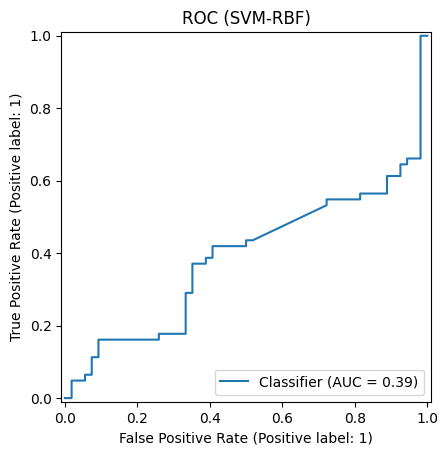


=== XGBOOST ===
Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}
XGBoost mean Acc: 0.655, AUC: 0.740

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6400    0.5926    0.6154        54
   parkinson     0.6667    0.7097    0.6875        62

    accuracy                         0.6552       116
   macro avg     0.6533    0.6511    0.6514       116
weighted avg     0.6543    0.6552    0.6539       116

Confusion matrix:
 [[32 22]
 [18 44]]


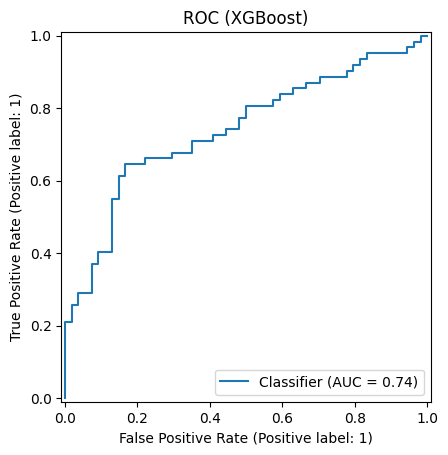

In [ ]:
# Colab: SVM-RBF + XGBoost with proper label encoding and CV
!pip -q install scikit-learn pandas numpy matplotlib xgboost

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# ---------- Load ----------
CSV_PATH = "/content/spiral_features_new_increased2.csv"   # adjust if needed
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

# ---------- Features / labels ----------
X = df[[c for c in df.columns if c not in {"path","label"}]]
y_raw = df["label"].astype(str)

# Encode labels: healthy=0, parkinson=1
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------- Cross-validation setup ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_model(name, model, param_grid):
    print(f"\n=== {name.upper()} ===")
    # GridSearchCV
    gs = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
    gs.fit(X, y)
    best_model = gs.best_estimator_
    print("Best params:", gs.best_params_)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=cv, method="predict")
    y_proba = cross_val_predict(best_model, X, y, cv=cv, method="predict_proba")[:,1]

    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    print(f"{name} mean Acc: {acc:.3f}, AUC: {auc:.3f}")
    print("\nClassification report (all folds pooled):")
    print(classification_report(y, y_pred, target_names=le.classes_, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC ({name})")
    plt.show()
    return best_model

# ---------- Models ----------
svm_rbf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])
svm_params = {"clf__C":[0.3,1,3,10], "clf__gamma":[0.001,0.003,0.01,0.03]}

xgb = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42,
    scale_pos_weight=len(y[y==0]) / len(y[y==1]) # handle class imbalance
)
xgb_params = {
    "n_estimators":[200,400],
    "max_depth":[3,6],
    "learning_rate":[0.05,0.1,0.2],
    "subsample":[0.8,1.0]
}

# ---------- Run ----------
best_svm = run_model("SVM-RBF", svm_rbf, svm_params)
best_xgb = run_model("XGBoost", xgb, xgb_params)


Loaded: (116, 89)
Class mapping: {'healthy': np.int64(0), 'parkinson': np.int64(1)}

=== SVM-RBF ===
Best params: {'clf__C': 0.3, 'clf__gamma': 0.001}
SVM-RBF CV Acc: 0.509, ROC-AUC: 0.394

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.4118    0.1296    0.1972        54
   parkinson     0.5253    0.8387    0.6460        62

    accuracy                         0.5086       116
   macro avg     0.4685    0.4842    0.4216       116
weighted avg     0.4724    0.5086    0.4370       116

Confusion matrix:
 [[ 7 47]
 [10 52]]


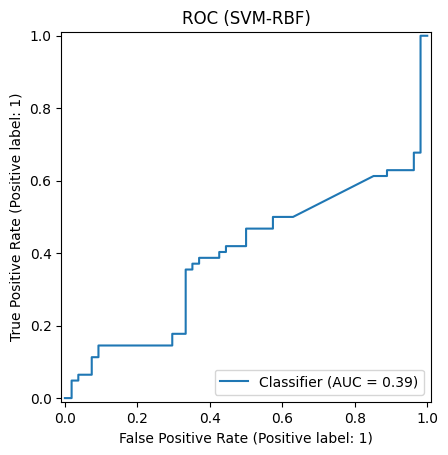


=== LOGREG ===
Best params: {'clf__C': 0.1}
LogReg CV Acc: 0.621, ROC-AUC: 0.639

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.5781    0.6852    0.6271        54
   parkinson     0.6731    0.5645    0.6140        62

    accuracy                         0.6207       116
   macro avg     0.6256    0.6249    0.6206       116
weighted avg     0.6289    0.6207    0.6201       116

Confusion matrix:
 [[37 17]
 [27 35]]


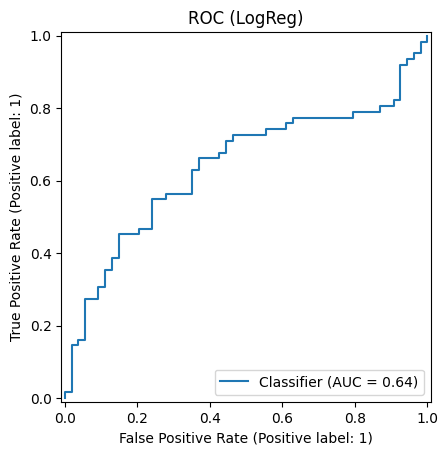


=== RANDOMFOREST ===
Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2}
RandomForest CV Acc: 0.655, ROC-AUC: 0.709

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6296    0.6296    0.6296        54
   parkinson     0.6774    0.6774    0.6774        62

    accuracy                         0.6552       116
   macro avg     0.6535    0.6535    0.6535       116
weighted avg     0.6552    0.6552    0.6552       116

Confusion matrix:
 [[34 20]
 [20 42]]


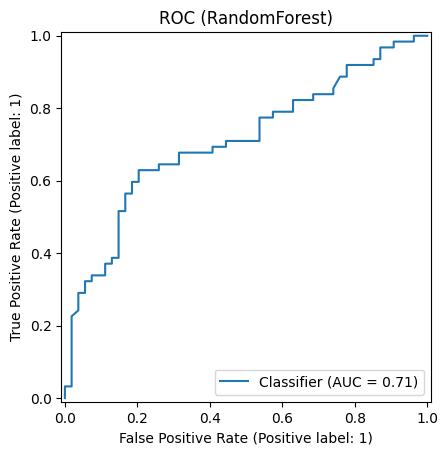


=== GRADIENTBOOSTING ===
Best params: {'clf__learning_rate': 0.05, 'clf__n_estimators': 200}
GradientBoosting CV Acc: 0.664, ROC-AUC: 0.707

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6316    0.6667    0.6486        54
   parkinson     0.6949    0.6613    0.6777        62

    accuracy                         0.6638       116
   macro avg     0.6632    0.6640    0.6632       116
weighted avg     0.6654    0.6638    0.6642       116

Confusion matrix:
 [[36 18]
 [21 41]]


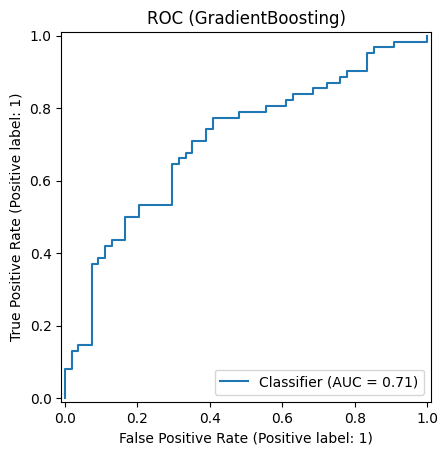


=== XGBOOST ===
Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}
XGBoost CV Acc: 0.655, ROC-AUC: 0.740

Classification report (all folds pooled):
              precision    recall  f1-score   support

     healthy     0.6400    0.5926    0.6154        54
   parkinson     0.6667    0.7097    0.6875        62

    accuracy                         0.6552       116
   macro avg     0.6533    0.6511    0.6514       116
weighted avg     0.6543    0.6552    0.6539       116

Confusion matrix:
 [[32 22]
 [18 44]]


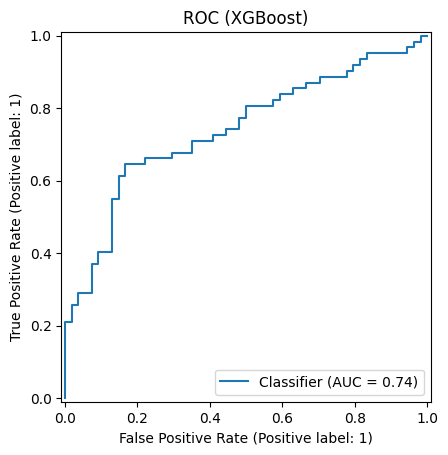


=== LIGHTGBM ===
[LightGBM] [Info] Number of positive: 62, number of negative: 54
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2656
[LightGBM] [Info] Number of data points in the train set: 116, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

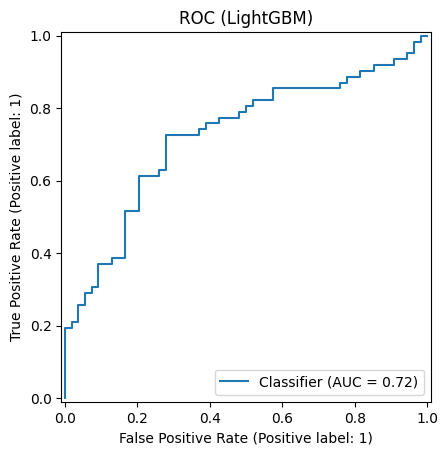

In [ ]:
# --- Install deps ---
!pip -q install scikit-learn pandas numpy matplotlib xgboost lightgbm

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# ---------- Load ----------
CSV_PATH = "/content/spiral_features_new_increased2.csv"   # change if needed
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

# ---------- Features / labels ----------
X = df[[c for c in df.columns if c not in {"path","label"}]]
y_raw = df["label"].astype(str)

# Encode labels: healthy=0, parkinson=1
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------- Cross-validation setup ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_model(name, model, param_grid):
    print(f"\n=== {name.upper()} ===")
    gs = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
    gs.fit(X, y)
    best_model = gs.best_estimator_
    print("Best params:", gs.best_params_)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=cv, method="predict")
    y_proba = cross_val_predict(best_model, X, y, cv=cv, method="predict_proba")[:,1]

    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    print(f"{name} CV Acc: {acc:.3f}, ROC-AUC: {auc:.3f}")
    print("\nClassification report (all folds pooled):")
    print(classification_report(y, y_pred, target_names=le.classes_, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC ({name})")
    plt.show()
    return best_model

# ---------- Pipelines ----------
base_pipe = [
    ("imp", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("sel", SelectKBest(f_classif, k=50))  # keep top 50 features
]

svm_rbf = Pipeline(base_pipe + [
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])
svm_params = {"clf__C":[0.3,1,3,10], "clf__gamma":[0.001,0.003,0.01,0.03]}

logreg = Pipeline(base_pipe + [
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", random_state=42))
])
logreg_params = {"clf__C":[0.1,1,10]}

rf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=42))
])
rf_params = {"clf__max_depth":[None,10,20], "clf__min_samples_split":[2,5]}

gb = Pipeline(base_pipe + [
    ("clf", GradientBoostingClassifier(random_state=42))
])
gb_params = {"clf__n_estimators":[200,400], "clf__learning_rate":[0.05,0.1]}

xgb = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42,
    scale_pos_weight=len(y[y==0]) / len(y[y==1])
)
xgb_params = {
    "n_estimators":[200,400],
    "max_depth":[3,6],
    "learning_rate":[0.05,0.1,0.2],
    "subsample":[0.8,1.0]
}

lgb = LGBMClassifier(random_state=42, class_weight="balanced")
lgb_params = {
    "n_estimators":[200,400],
    "num_leaves":[15,31,63],
    "learning_rate":[0.05,0.1,0.2]
}

# ---------- Run all ----------
best_svm = run_model("SVM-RBF", svm_rbf, svm_params)
best_logreg = run_model("LogReg", logreg, logreg_params)
best_rf = run_model("RandomForest", rf, rf_params)
best_gb = run_model("GradientBoosting", gb, gb_params)
best_xgb = run_model("XGBoost", xgb, xgb_params)
best_lgb = run_model("LightGBM", lgb, lgb_params)
